In [2]:
# external imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn import svm
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# internal imports
import sys
sys.path.insert(0,'../')
from data_utils import add_deltas_and_time, scale_data, column_combinations, add_extreme, add_lifetime

In [3]:
data_850 = pd.read_csv('../NA850data_2000-2014.csv')
data_wtreme = add_extreme(data_850)
data_w_time_deltas = add_deltas_and_time(data_wtreme)
data_w_lifetime = add_lifetime(data_w_time_deltas)

In [4]:
# get scaled provided data with deltas and time added
X = data_w_lifetime.drop(columns=['LH', 'dLH', "Extreme", "dExtreme"])
X = scale_data(X)

y = data_w_lifetime['LH']
y_extreme = data_w_lifetime['Extreme']

X.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,LifeTime
Time,,,,,,,,,,,,,,,,,,,
2000-01-01 03:00:00,-6.088163,-0.910811,0.080339,2.180997,-0.718670,-1.008888,1.243533,0.004734,-0.954545,-1.168067,0.091148,0.195511,-0.799627,-0.251402,0.394266,1.285404,-1.218041,-1.279085,-1.50
2000-01-01 06:00:00,-6.107434,-0.943091,0.476626,1.966440,-0.527986,-0.698457,1.264110,-0.049866,-0.909091,-1.168067,-0.035440,-0.160021,0.530617,-0.388836,0.580967,0.711946,0.271371,-0.790392,-1.50
2000-01-01 09:00:00,-5.950378,-1.005994,0.800095,2.043946,-0.458774,-0.685136,1.199761,-0.092620,-0.863636,-1.168067,0.483702,-0.295208,0.433411,0.098812,0.214843,0.011722,-1.105129,-0.386217,-1.50
2000-01-01 12:00:00,-5.787819,-0.943555,0.508682,2.555672,-0.569586,-0.490811,1.229895,-0.155015,-0.818182,-1.168067,0.499905,0.258125,-0.387412,0.823818,-0.327761,0.438309,0.426290,-1.056380,-1.25
2000-01-01 15:00:00,-5.531023,-0.874945,0.388518,2.123726,-0.611146,-0.452270,1.246959,-0.213574,-0.772727,-1.168067,0.777359,0.285370,-0.158807,-0.751805,-0.119031,0.071160,0.214437,-0.925509,-1.25


In [96]:
undersampler = RandomUnderSampler(sampling_strategy=1, random_state=5)
X_under, y_under = undersampler.fit_resample(X, y_extreme)

In [6]:
LQ = data_850.LH.quantile(0.25)
UQ = data_850.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ)  # Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound

def classifyextremes(y_pred):
    return np.where((y_pred > upper_bound) | (y_pred < lower_bound), 1, 0)

<AxesSubplot:xlabel='LH'>

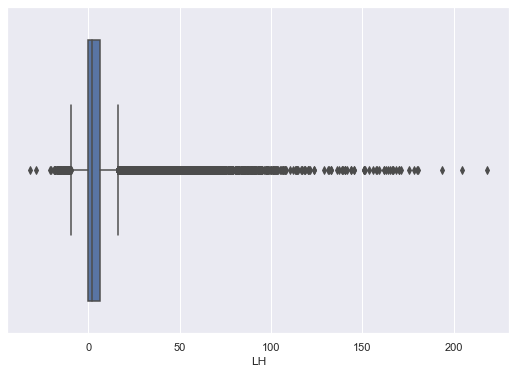

In [85]:
sns.set(rc={'figure.figsize':(9,6)})
sns.boxplot(x=data_wtreme["LH"])

<AxesSubplot:xlabel='LH'>

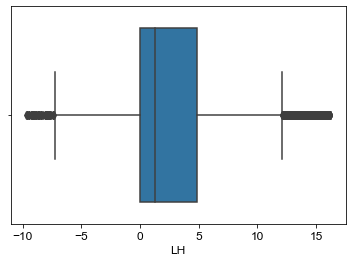

In [82]:
#sns.boxplot(x=data_wtreme[data_wtreme.Extreme != 1]["LH"])

In [45]:
preselected_features = ["AirTemp", "QV", "Omega"]
features_to_select = [feature for feature in X.columns if feature not in preselected_features]
features_to_select.remove("PtIndex")

In [46]:
clf_rbf = svm.SVC(kernel = 'rbf', C = 10)

X_train, X_test, y_train, y_test = \
    train_test_split(X_under, y_under, test_size=0.2, random_state=2)

# initialize metric list
log_csv = []

# test over all combinations of a maximum length
for comb in tqdm(column_combinations(features_to_select, max_len=5), desc=f"Training and Testing..."):
    feats = preselected_features + comb
    # train and test inputs
    X_train_feat = X_train[feats]
    X_test_feat = X_test[feats]

    # fit and predict train and test
    clf_rbf.fit(X_train_feat, y_train)
    y_pred_train = clf_rbf.predict(X_train_feat)
    y_pred_test = clf_rbf.predict(X_test_feat)

    # log training and testing metrics to list
    log_csv.append(
        [feats,
        mean_squared_error(y_train, y_pred_train),  # train MSE
        mean_squared_error(y_test, y_pred_test),  # test MSE
        r2_score(y_train, y_pred_train),  # train r^2
        r2_score(y_test, y_pred_test),  # test r^2
        accuracy_score(y_train, y_pred_train),  # train accuracy
        accuracy_score(y_test, y_pred_test),  # test accuracy
        f1_score(y_train, y_pred_train),  # train f1
        f1_score(y_test, y_pred_test)]  # test f1
    )

Training and Testing...:   0%|          | 0/4943 [00:00<?, ?it/s]

In [49]:
log_csv_sorted = sorted(log_csv, key=lambda l: l[-1], reverse=True)  # sort by max testing f1
# convert to dataframe and write to file
log_df = pd.DataFrame(log_csv_sorted, columns=["feature_combination", "train_MSE",
                                               "test_MSE", "train_r^2", "test_r^2", "train_acc",
                                               "test_acc", "train_F1", "test_F1"])
#  Save to CSV
#log_df.to_csv("SVM_results.csv", index=False)

In [54]:
features = {}
for i in log_df[:10].feature_combination:
    for j in i:
        try:
            features[j] += 1
        except:
            features[j] = 1
features = {k: v for k, v in sorted(features.items(), reverse=True, key=lambda item: item[1])}

<BarContainer object of 14 artists>

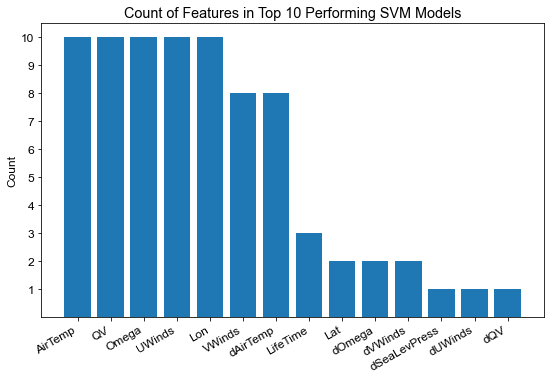

In [55]:
import matplotlib

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(9,6))

names = list(features.keys())
values = list(features.values())
fig.autofmt_xdate()
plt.yticks([x for x in np.arange(1, 11)])
plt.ylabel("Count")
plt.title("Count of Features in Top 10 Performing SVM Models")
plt.bar(range(len(features)), values, tick_label=names)

In [56]:
for i in log_df[:10].feature_combination:
    print(i)

['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'dAirTemp', 'dSeaLevPress']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lat', 'Lon', 'dAirTemp']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'dAirTemp']
['AirTemp', 'QV', 'Omega', 'UWinds', 'Lon', 'dAirTemp', 'dOmega', 'dVWinds']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lat', 'Lon', 'dVWinds']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'dAirTemp', 'LifeTime']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'LifeTime']
['AirTemp', 'QV', 'Omega', 'UWinds', 'Lon', 'dAirTemp', 'dOmega', 'LifeTime']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'dAirTemp', 'dUWinds']
['AirTemp', 'QV', 'Omega', 'UWinds', 'VWinds', 'Lon', 'dAirTemp', 'dQV']


In [57]:
log_df[:10]

,feature_combination,train_MSE,test_MSE,train_r^2,test_r^2,train_acc,test_acc,train_F1,test_F1
0,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.109412,0.090909,0.562245,0.634929,0.890588,0.909091,0.887636,0.911854
1,"[AirTemp, QV, Omega, UWinds, VWinds, Lat, Lon,...",0.109412,0.090909,0.562245,0.634929,0.890588,0.909091,0.888176,0.911585
2,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.112941,0.092476,0.548124,0.628634,0.887059,0.907524,0.884523,0.910470
3,"[AirTemp, QV, Omega, UWinds, Lon, dAirTemp, dO...",0.101961,0.092476,0.592056,0.628634,0.898039,0.907524,0.894652,0.909648
4,"[AirTemp, QV, Omega, UWinds, VWinds, Lat, Lon,...",0.112549,0.094044,0.549693,0.622340,0.887451,0.905956,0.884228,0.909091
5,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.108627,0.094044,0.565383,0.622340,0.891373,0.905956,0.889067,0.908257
6,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, Life...",0.112941,0.095611,0.548124,0.616046,0.887059,0.904389,0.884708,0.907994
7,"[AirTemp, QV, Omega, UWinds, Lon, dAirTemp, dO...",0.105490,0.094044,0.577935,0.622340,0.894510,0.905956,0.892357,0.907975
8,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.102745,0.095611,0.588918,0.616046,0.897255,0.904389,0.894525,0.907716
9,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.105490,0.095611,0.577935,0.616046,0.894510,0.904389,0.891924,0.907436


## Different Cost Values

In [58]:
log_cost_csv = []

for entry in tqdm(log_csv_sorted[:100], desc="Training and Testing..."):
    feats = entry[0]
    
    for cost in [x**2 for x in np.arange(1, 11)]:
        clf_rbf = svm.SVC(kernel = 'rbf', C = cost)
        
        # train and test inputs
        X_train_feat = X_train[feats]
        X_test_feat = X_test[feats]

        # fit and predict train and test
        clf_rbf.fit(X_train_feat, y_train)
        y_pred_train = clf_rbf.predict(X_train_feat)
        y_pred_test = clf_rbf.predict(X_test_feat)

        # log training and testing metrics to list
        log_cost_csv.append(
            [cost, feats,
            mean_squared_error(y_train, y_pred_train),  # train MSE
            mean_squared_error(y_test, y_pred_test),  # test MSE
            r2_score(y_train, y_pred_train),  # train r^2
            r2_score(y_test, y_pred_test),  # test r^2
            accuracy_score(y_train, y_pred_train),  # train accuracy
            accuracy_score(y_test, y_pred_test),  # test accuracy
            f1_score(y_train, y_pred_train),  # train f1
            f1_score(y_test, y_pred_test)]  # test f1
        )

Training and Testing...:   0%|          | 0/100 [00:00<?, ?it/s]

In [59]:
log_cost_csv_sorted = sorted(log_cost_csv, key=lambda l: l[-1], reverse=True)  # sort by max testing f1
# convert to dataframe and write to file
log_cost_df = pd.DataFrame(log_cost_csv_sorted, columns=["cost", "feature_combination", "train_MSE",
                                               "test_MSE", "train_r^2", "test_r^2", "train_acc",
                                               "test_acc", "train_F1", "test_F1"])
#log_cost_df.to_csv("SVM_cost_results.csv", sep="|", index=False)

In [73]:
log_cost_df[:1]

,cost,feature_combination,train_MSE,test_MSE,train_r^2,test_r^2,train_acc,test_acc,train_F1,test_F1
0,16,"[AirTemp, QV, Omega, UWinds, VWinds, Lon, dAir...",0.1,0.089342,0.599902,0.641223,0.9,0.910658,0.897384,0.913505


In [152]:
# Heatmap of Cost vs Feature Count vs F1 Score
import seaborn as sns
import matplotlib

Text(0.5, 1.0, 'Average F1 Score vs Cost for Top 100 Models')

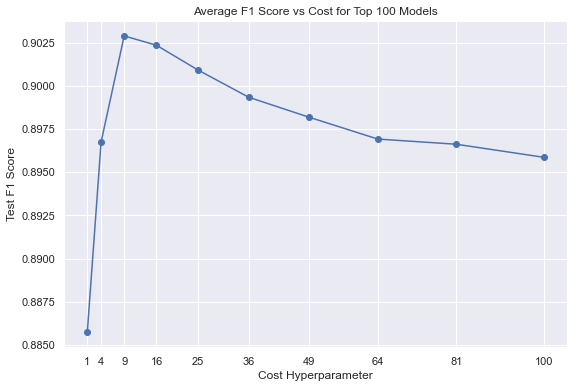

In [87]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

plot = plt.figure(figsize=(9,6))
avgs = [log_cost_df[log_cost_df.cost == cost].test_F1.mean() for cost in [x**2 for x in np.arange(1, 11)]]
plt.plot([x**2 for x in np.arange(1, 11)], avgs, marker='o')
plt.xticks([x**2 for x in np.arange(1, 11)])
plt.ylabel("Test F1 Score")
plt.xlabel("Cost Hyperparameter")
plt.title("Average F1 Score vs Cost for Top 100 Models")

In [88]:
avgs

[0.8857370715661114,
 0.8967517514685267,
 0.9028840182955514,
 0.9023444743800758,
 0.9009138061957487,
 0.8993389151568576,
 0.8981906121139341,
 0.8969191971671914,
 0.8966203905828471,
 0.8958644755791244]

In [140]:
log_cost_df[log_cost_df.cost ==1].test_F1.mean()

0.8839455171193797

In [164]:
temp = ['AirTemp', 'QV', 'Omega', 'VWinds', 'UWinds', 'Lon', 'dAirTemp', 'dSeaLevPress', 'LifeTime']
# train and test inputs
X_train_feat = X_train[temp]
X_test_feat = X_test[temp]

# fit and predict train and test
clf_rbf.fit(X_train_feat, y_train)
y_pred_train = clf_rbf.predict(X_train_feat)
y_pred_test = clf_rbf.predict(X_test_feat)

In [167]:
print(accuracy_score(y_train, y_pred_train))  # train accuracy
print(accuracy_score(y_test, y_pred_test))  # test accuracy
print(f1_score(y_train, y_pred_train))  # train f1
print(f1_score(y_test, y_pred_test))  # test f1

0.9211764705882353
0.8918495297805643
0.9199522102747909
0.8946564885496182


In [186]:
X

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,dAirTemp,dQV,dOmega,dSeaLevPress,dUWinds,dVWinds,dLat,dLon,LifeTime
Time,,,,,,,,,,,,,,,,,,,
2000-01-01 03:00:00,-6.088163,-0.910811,0.080339,2.180997,-0.718670,-1.008888,1.243533,0.004734,-0.954545,-1.168067,0.091148,0.195511,-0.799627,-0.251402,0.394266,1.285404,-1.218041,-1.279085,-1.50
2000-01-01 06:00:00,-6.107434,-0.943091,0.476626,1.966440,-0.527986,-0.698457,1.264110,-0.049866,-0.909091,-1.168067,-0.035440,-0.160021,0.530617,-0.388836,0.580967,0.711946,0.271371,-0.790392,-1.50
2000-01-01 09:00:00,-5.950378,-1.005994,0.800095,2.043946,-0.458774,-0.685136,1.199761,-0.092620,-0.863636,-1.168067,0.483702,-0.295208,0.433411,0.098812,0.214843,0.011722,-1.105129,-0.386217,-1.50
2000-01-01 12:00:00,-5.787819,-0.943555,0.508682,2.555672,-0.569586,-0.490811,1.229895,-0.155015,-0.818182,-1.168067,0.499905,0.258125,-0.387412,0.823818,-0.327761,0.438309,0.426290,-1.056380,-1.25
2000-01-01 15:00:00,-5.531023,-0.874945,0.388518,2.123726,-0.611146,-0.452270,1.246959,-0.213574,-0.772727,-1.168067,0.777359,0.285370,-0.158807,-0.751805,-0.119031,0.071160,0.214437,-0.925509,-1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-13 21:00:00,-1.941194,-0.494665,0.885603,0.177027,0.348260,0.096203,1.123704,-0.583868,1.318182,0.840336,-0.027149,0.569850,1.516317,0.444906,0.146199,-0.451563,-0.134497,0.431239,0.75
2014-12-14 00:00:00,-2.099851,-0.619581,-0.258857,0.490998,0.471647,0.726444,1.123706,-0.597200,1.363636,0.840336,-0.445823,-0.568970,-1.526166,0.493632,0.378130,1.465666,-0.062097,0.617671,0.75
2014-12-14 03:00:00,-1.874915,-0.438409,0.725923,0.271957,0.776198,0.636039,1.109494,-0.608814,1.409091,0.840336,0.683556,0.782283,1.316212,-0.396324,0.924174,-0.232735,-0.292494,0.676251,1.00


In [ ]:
import matplotlib.pylab as pylab

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

C:\Users\srimo\miniconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\srimo\miniconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\srimo\miniconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


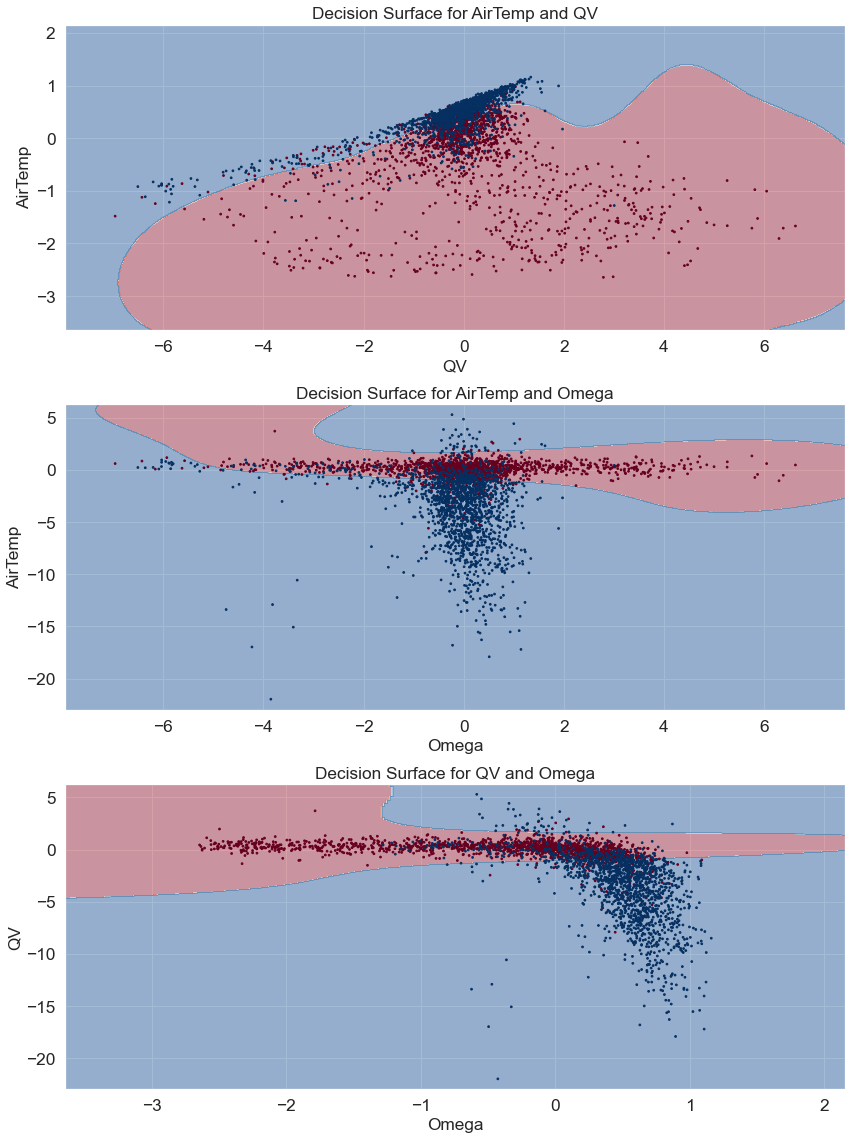

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X_under[['AirTemp', 'QV']], y_under, test_size=0.25, random_state=738)
clf_rbf = svm.SVC(kernel = 'rbf', C = 9)
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_test)

fig, ax = plt.subplots(3, figsize=(12,16))
# title for the plots
title = ('Decision Surface for AirTemp and QV')
# Set-up grid for plotting.
X0, X1 = X_under["AirTemp"], X_under["QV"]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax[0], clf_rbf, xx, yy, cmap=plt.cm.RdBu, alpha=0.4)
ax[0].scatter(X0, X1, c=y_under, cmap=plt.cm.RdBu, s=3)
ax[0].set_ylabel('AirTemp')
ax[0].set_xlabel('QV')
ax[0].set_title(title)

X_train, X_test, y_train, y_test = train_test_split(X_under[['AirTemp', 'Omega']], y_under, test_size=0.25, random_state=738)
clf_rbf = svm.SVC(kernel = 'rbf', C = 9)
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_test)

# title for the plots
title = ('Decision Surface for AirTemp and Omega')
# Set-up grid for plotting.
X0, X1 = X_under["AirTemp"], X_under["Omega"]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax[1], clf_rbf, xx, yy, cmap=plt.cm.RdBu, alpha=0.4)
ax[1].scatter(X0, X1, c=y_under, cmap=plt.cm.RdBu, s=3)
ax[1].set_ylabel('AirTemp')
ax[1].set_xlabel('Omega')
ax[1].set_title(title)

X_train, X_test, y_train, y_test = train_test_split(X_under[['QV', 'Omega']], y_under, test_size=0.25, random_state=738)
clf_rbf = svm.SVC(kernel = 'rbf', C = 9)
clf_rbf.fit(X_train, y_train)
y_pred = clf_rbf.predict(X_test)

# title for the plots
title = ('Decision Surface for QV and Omega')
# Set-up grid for plotting.
X0, X1 = X_under["QV"], X_under["Omega"]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax[2], clf_rbf, xx, yy, cmap=plt.cm.RdBu, alpha=0.4)
ax[2].scatter(X0, X1, c=y_under, cmap=plt.cm.RdBu, s=3)
ax[2].set_ylabel('QV')
ax[2].set_xlabel('Omega')
ax[2].set_title(title)
plt.tight_layout()
plt.show()